In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import copy
from utils import merge_image_superpixels

In [2]:
image_names = ["2007_000068", "2007_000121", "2007_000123"]
voc_ext = ".jpg"
gt_ext = ".png"

voc_dir = "data/voc12/"
gt_dir = "data/gt/"

images = []
gt_images = []

images_gray = []

for name in image_names:
    img = cv2.imread(voc_dir + name + voc_ext)
    gt = cv2.imread(gt_dir + name + gt_ext)
   
    images.append(img)
    gt_images.append(gt)

    images_gray.append(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY))

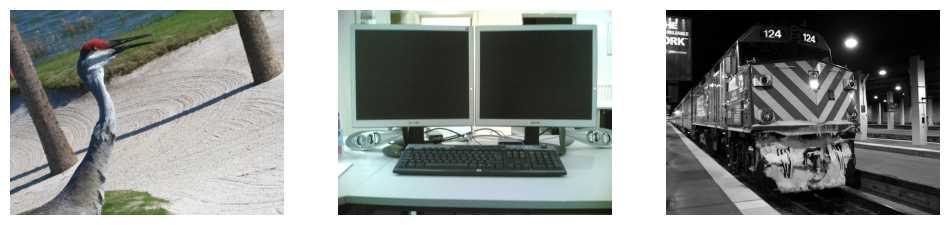

In [3]:
fig = plt.figure(figsize=(12, 4))

rows = 1
cols = 3

for i, img in enumerate(images):
    fig.add_subplot(rows, cols, i+1)
    plt.axis("off")
    plt.imshow(img[:,:,::-1])

## Superpixels

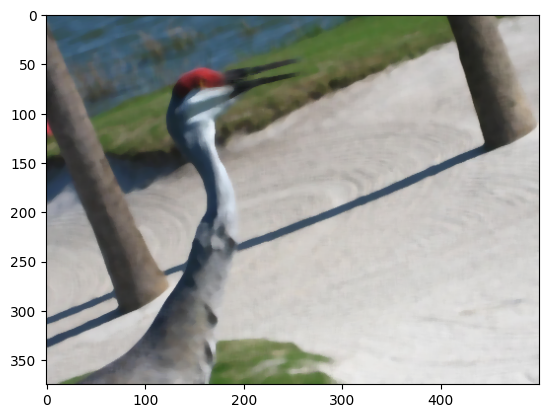

In [4]:
median_blurred = cv2.medianBlur(images[0], 7)
plt.imshow(median_blurred[:,:,::-1])

In [72]:
use_blurred = True
lab_img = cv2.cvtColor(images[0], cv2.COLOR_BGR2Lab)

if use_blurred:
    lab_img = cv2.cvtColor(median_blurred, cv2.COLOR_BGR2Lab)

superpixels_slic = cv2.ximgproc.createSuperpixelSLIC(lab_img, algorithm=cv2.ximgproc.SLIC, region_size=24)
superpixels_slic.iterate()
superpixels_slic_mask = superpixels_slic.getLabelContourMask()
print(superpixels_slic.getNumberOfSuperpixels())

height, width, channels = lab_img.shape[0], lab_img.shape[1], lab_img.shape[2]

superpixels_seeds = cv2.ximgproc.createSuperpixelSEEDS(width, height, channels, 500, 5)
superpixels_seeds.iterate(lab_img)
superpixels_seeds_mask = superpixels_seeds.getLabelContourMask()
print(superpixels_seeds.getNumberOfSuperpixels())

superpixels_lsc = cv2.ximgproc.createSuperpixelLSC(lab_img, region_size=24)
superpixels_lsc.iterate()
superpixels_lsc_mask = superpixels_lsc.getLabelContourMask()
print(superpixels_lsc.getNumberOfSuperpixels())

336
165
320


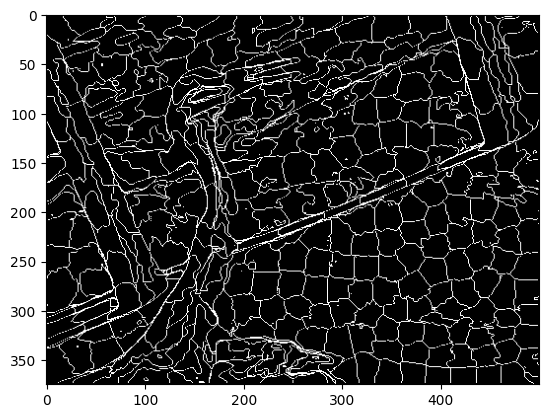

In [73]:
plt.imshow(superpixels_slic_mask, cmap="gray")

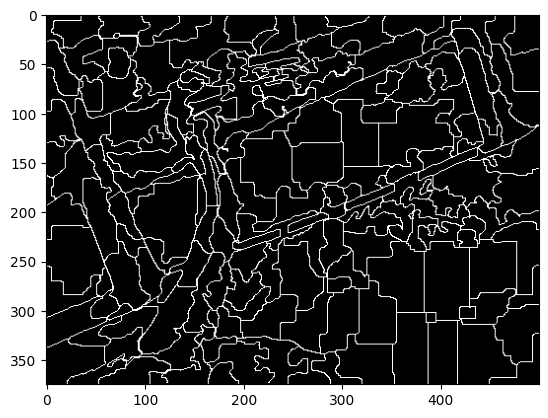

In [74]:
plt.imshow(superpixels_seeds_mask, cmap="gray")

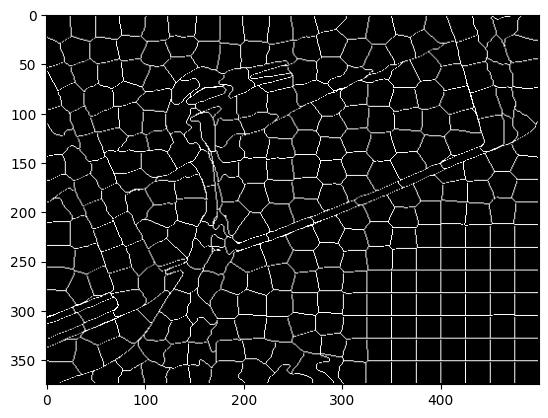

In [75]:
plt.imshow(superpixels_lsc_mask, cmap="gray")

In [76]:
superpixel_contour_img = merge_image_superpixels(images[0], superpixels_lsc_mask, [0,255,0])

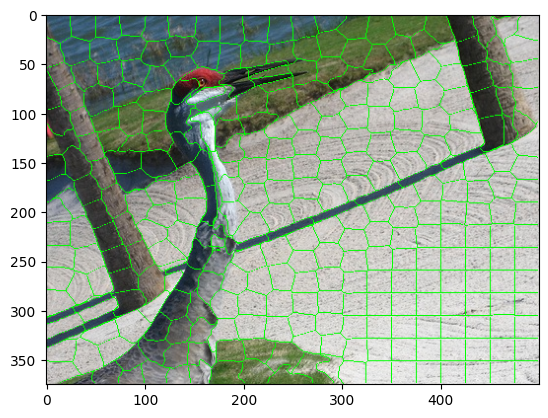

In [77]:
plt.imshow(superpixel_contour_img[:,:,::-1])

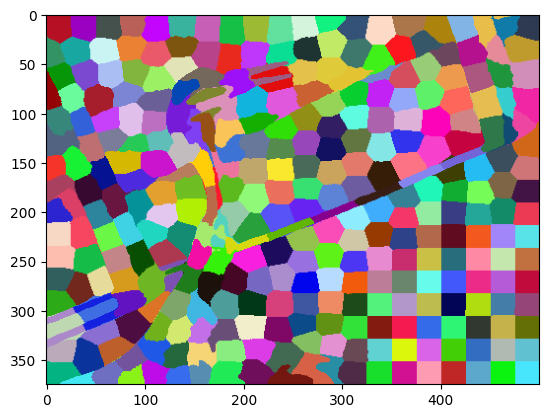

In [78]:
superpixel_labels = superpixels_lsc.getLabels()

visualization_superpixels = np.zeros((superpixel_labels.shape[0],superpixel_labels.shape[1],3), np.uint8)
random_colors = []

for i in np.unique(superpixel_labels):
    random_colors.append(np.random.randint(0,256,(3,)))
for i in range(superpixel_labels.shape[0]):
    for j in range(superpixel_labels.shape[1]):
        visualization_superpixels[i, j] = random_colors[superpixel_labels[i, j]]

plt.imshow(visualization_superpixels)

In [79]:
mean_img = np.zeros(images[0].shape, np.uint8)

for i in np.unique(superpixel_labels):
    mask = np.where(superpixel_labels == i, 1, 0).astype(np.uint8)
    mean = cv2.mean(images[0], mask=mask)
    mean_img[mask==1] = mean[:3]

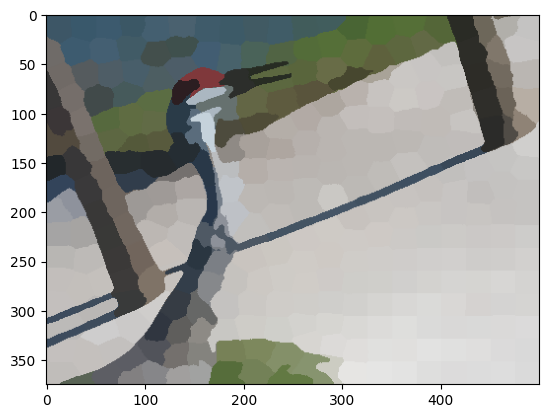

In [80]:
plt.imshow(mean_img[:,:,::-1])

## Semi-supervised mask creation

In [12]:
# click on superpixels

# idea: priemerna hodnota kazdeho superpixelu -> "kachlickovy" obrazok -> potom floodfill
# potom grabcut

# alebo naklikanie hranicnych superpixelov - tie budu possible foreground a vnutri budu sure foreground

# https://stackoverflow.com/questions/32822856/how-to-access-the-segments-of-the-image
# getLabel -> vytvorit z toho matrix a s nim pracovat

In [86]:
my_img = copy.deepcopy(mean_img)

seed_point = (100,350)
_ = cv2.floodFill(my_img, None, seed_point, [255,255,255], loDiff=(4,4,4,4), upDiff=(10,10,10,10))

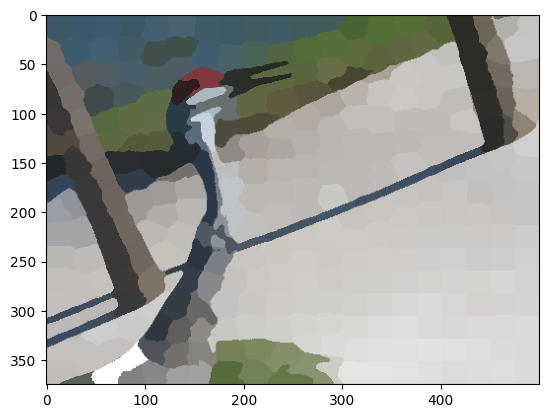

In [87]:
plt.imshow(my_img[:,:,::-1])